In [1]:
%matplotlib inline

import gzip
import json
import os

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import FuncFormatter

def load_stats(d):
    out = []

    for n in sorted(os.listdir(d)):
        with gzip.open(os.path.join(d, n)) as f:
            data = json.load(f)
            v = tuple(map(int, data['tag'][1:].split('.')))
            out.append((v, data))

    return list(v[1] for v in sorted(out, key=lambda v: v[0]))

def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

def percentages(x, pos):
    return '%1.2f%%' % (x * 100)

def stack_plot(datasets, formatter=millions):
    golden = (1 + 5 ** 0.5) / 2
    figure(num=None, figsize=(16 * golden, 16), dpi=80, facecolor='w', edgecolor='k')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(formatter))
    width = 0.6

    with plt.style.context(['seaborn-muted']):
        bottom = None

        plt.grid(True, axis='y')

        for dataset in datasets:
            kw = dict()

            if bottom is None:
                bottom = dataset
            else:
                kw['bottom'] = list(bottom)
                # calculate next bottom.
                bottom = [a + b for (a, b) in zip(bottom, dataset)]

            plt.bar(tags, dataset, width, **kw)

        plt.title("Lines of code in the Linux kernel\nGenerated using {}".format(URL))
        plt.legend(legends, loc='upper left')
        plt.xticks(rotation=45)

URL = "https://github.com/udoprog/kernelstats"

In [2]:
stats = load_stats("stats")

lang_filter = set([
    'Assembly',
    'C',
    'CHeader',
    'Makefile',
    'Cpp',
    'CppHeader',
    'Sh',
    'Python',
    'Perl',
    'Ruby',
])

separate_set = set([
    "drivers",
    "fs",
    "ipc",
    "net",
    "drivers/gpu",
    "drivers/net",
    "drivers/media",
])    

important_set = set([
    "mm",
    "crypto",
    "sound",
])
important_name = ", ".join(sorted(important_set))

ignored = set([
    'Documentation',
    'scripts',
    'lib',
    'init',
])

arch_whitelist = set([
    'i386',
    'x86',
    'x86_64',
])

arch_whitelist_name = ", ".join(map(lambda a: "arch/{}".format(a), sorted(arch_whitelist)))

# Require at least 50k LOC to show up.
criteria = 50_000
keys = set()
releases = []

def section_name(parts):
    """
    Calculate a section name from a set of parts.
    """
    # not a directory
    if len(parts) <= 2:
        return None

    name = parts[1]

    if name == "arch":
        if len(parts) >= 3:
            arch = parts[2]

            if arch in arch_whitelist:
                return arch_whitelist_name
            else:
                return "arch/other"

        raise Exception("bad arch: " + repr(parts))

    if name == "drivers":
        if len(parts) >= 3:
            sub_name = name + '/' + parts[2]

            if sub_name in separate_set:
                return sub_name

        return "drivers/other"
    
    if name in separate_set:
        return name

    if name in important_set:
        return important_name

    return "other"

for s in stats:
    sections = {}

    for (lang, data) in s['all'].items():
        for file_s in data['stats']:
            parts = file_s['name'].split('/')
            name = section_name(parts)
            
            if name is None:
                continue

            if lang not in lang_filter:
                continue

            try:
                sections[name] += file_s['code']
            except KeyError:
                sections[name] = file_s['code']

            if sections[name] > criteria:
                keys.add(name)

    total = sum(s for s in sections.values())
    
    percentage_sections = dict()
    
    for (name, value) in sections.items():
        percentage_sections[name] = value / total

    releases.append({
        "tag": s['tag'],
        "sections": sections,
        "percentage_sections": percentage_sections,
    })

legends = []
datasets = []
percentage_datasets = []
tags = [r['tag'] for r in releases]

for key in sorted(keys):
    if key in ignored:
        continue
    
    values = []
    percentage_values = []
    
    for r in releases:
        try:
            lines = r['sections'][key]
        except KeyError:
            lines = 0

        values.append(lines)

        try:
            percentage_lines = r['percentage_sections'][key]
        except KeyError:
            percentage_lines = 0

        percentage_values.append(percentage_lines)

    datasets.append(values)
    percentage_datasets.append(percentage_values)
    legends.append(key)

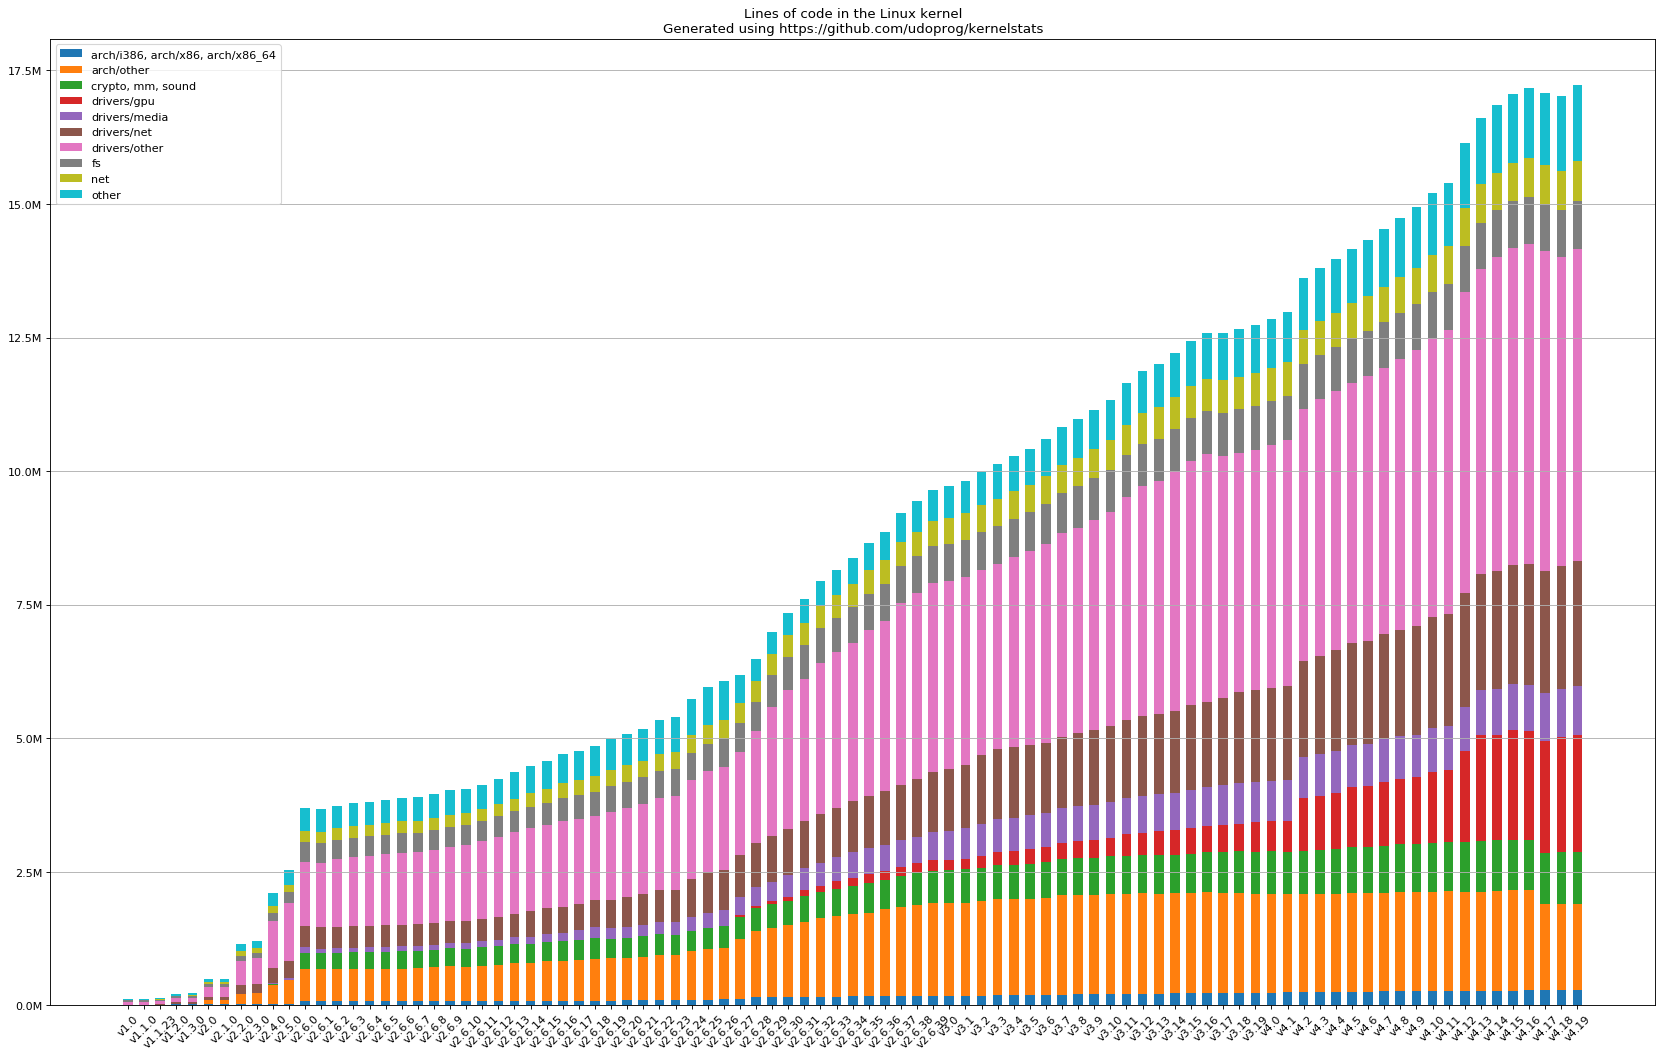

In [3]:
stack_plot(datasets, formatter=millions)
plt.savefig('kernelstats-millions.png')

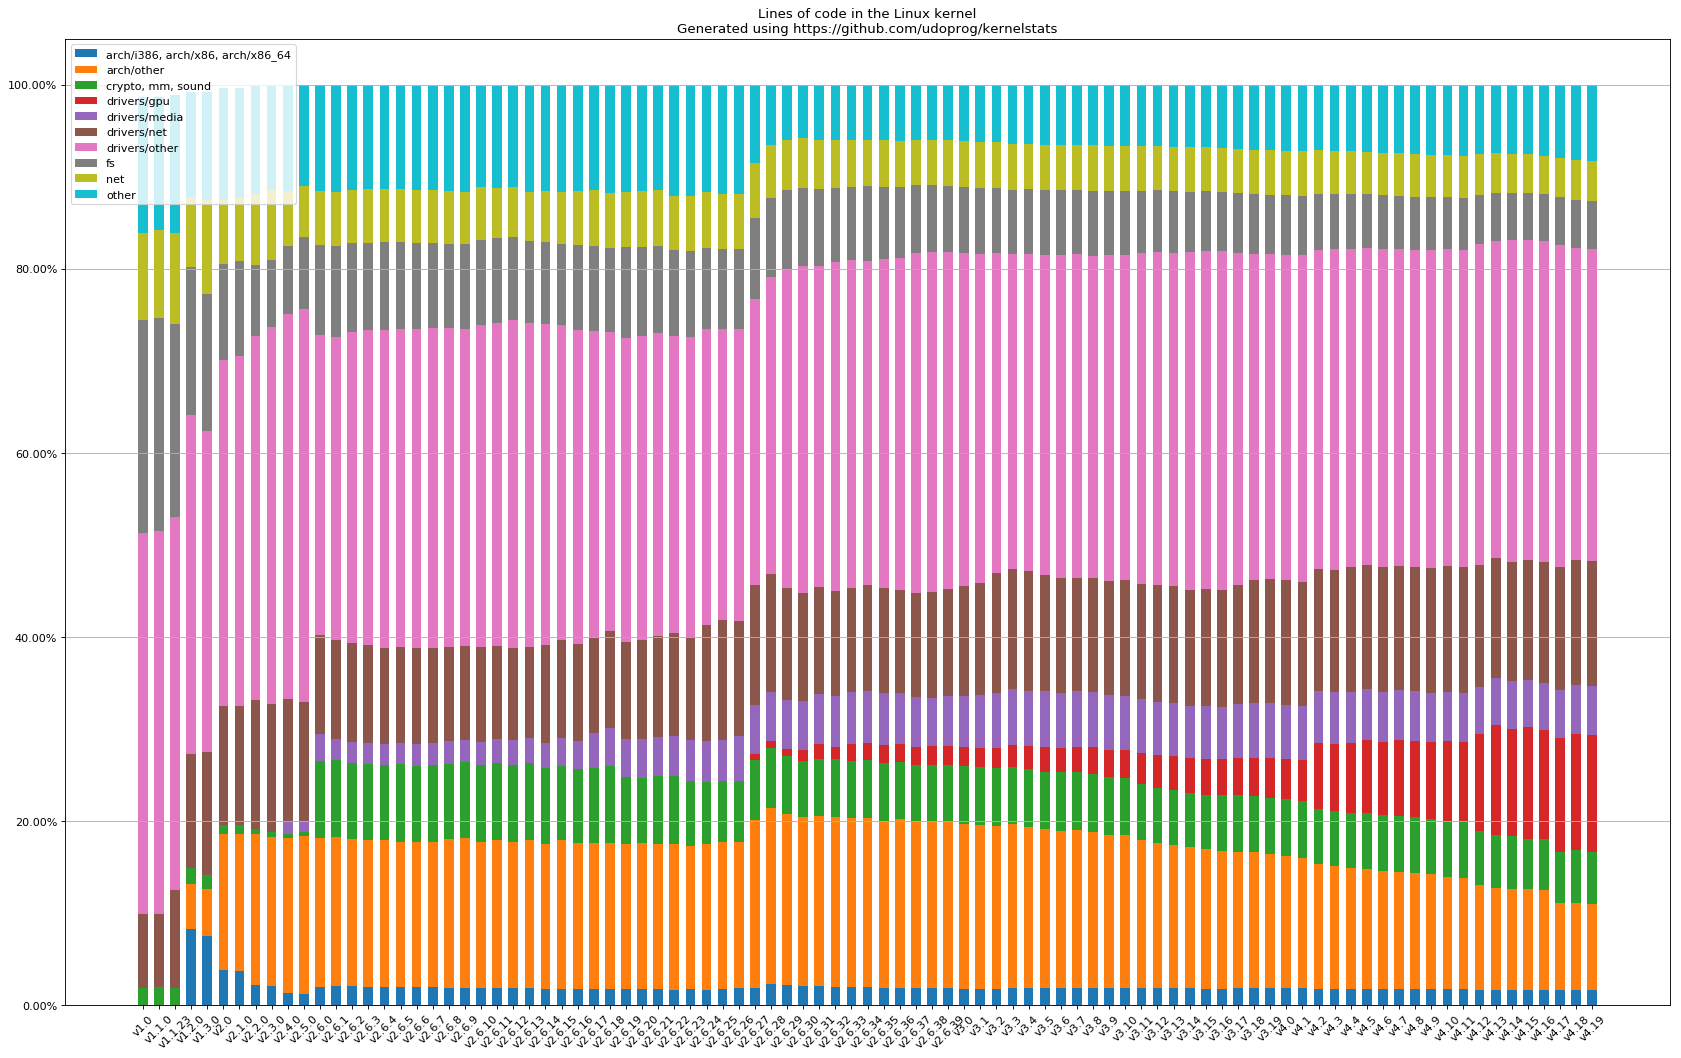

In [4]:
stack_plot(percentage_datasets, formatter=percentages)
plt.savefig('kernelstats-percentages.png')